The purpose of this notebook is to show how to **calibrate and integrate** XRD data using pyFAI library.

See pyFAI tutorial here: (https://www.youtube.com/watch?v=j0cphX3z2mM&ab_channel=ESRFsynchrotron)
See pyFAI documents here: (https://pyfai.readthedocs.io/en/stable/)

At 28ID-2-D-tomo beamline endstation of NSLS-II, we mainly use two different area detectors:

* PerkinElmer : https://resources.perkinelmer.com/corporate/pdfs/downloads/bro_digitalxraydetectors.pdf
* Dexela 2923 : https://www.sciencedirect.com/science/article/pii/S0168900212006730



# general imports

In [1]:
# We need to import some Python libraries here first.

import os
import sys
import shutil
import scipy
import time

import numpy as np
import xarray as xr


from IPython.display import clear_output


In [8]:
# We need import pyFAI,PyQt5,ipympl packages (if not available pip-install)
try:
    import ipympl
except:
    !!pip install ipympl
    import ipympl

# if running on google colab
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass

try:
    import PyQt5
except:
    !!pip install PyQt5

try:
    import pyFAI
except:
    !!pip install pyfai
    import pyFAI

In [9]:
%matplotlib widget

# importing matplotlib for plots.
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.constrained_layout.use'] = True

# setting up the example data path

In [10]:
# We assume this notebook and its data is on Google Drive so that we can use Google Colab.
# Otherwise, replace XXX with the exact path where this notebook (000.read_research_data_into_python.ipynb)
# and its data folder (000.read_research_data_into_python.data) is.

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/SULI-2024/repositories/pySULI/notebooks/')
    from google.colab import output
    output.enable_custom_widget_manager()

except Exception as exc:
    print(exc)
    os.chdir('.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Assuming 002.learn_pyFAI.data folder is here.

here = os.getcwd()
example_data_path = '002.learn_pyFAI.data'

# navigate into example_data_path directory
os.chdir(example_data_path)

os.listdir('.')

['from_PerkinElmer_detector', 'from_Dexela2923_detector', '.ipynb_checkpoints']

# Re-calibration of a diffraction image with Jupyter

In [12]:
# from_PerkinElmer_detector folder has calibration.poni file with content below:
%cat from_PerkinElmer_detector/calibration.poni

# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
# Calibration done at Tue Dec  5 17:23:16 2023
poni_version: 2
Detector: Perkin
Detector_config: {"pixel1": 0.0002, "pixel2": 0.0002}
Distance: 1.4280177479893559
Poni1: 0.23398429857415295
Poni2: 0.37634908408057827
Rot1: -0.003994332959290178
Rot2: -0.026132616520970278
Rot3: -4.71036871681453e-10
Wavelength: 1.814e-11


In [14]:
# Create a "normal" azimuthal integrator from provided calibration poni file
ai_provided = pyFAI.load('from_PerkinElmer_detector/calibration.poni')
ai_provided

Detector Perkin detector	 PixelSize= 2.000e-04, 2.000e-04 m
Wavelength= 1.814000e-11 m
SampleDetDist= 1.428018e+00 m	PONI= 2.339843e-01, 3.763491e-01 m	rot1=-0.003994  rot2=-0.026133  rot3=-0.000000 rad
DirectBeamDist= 1428.517 mm	Center: x=1910.265, y=983.288 pix	Tilt= 1.515° tiltPlanRotation= -81.312° 𝛌= 0.181Å

\
Here we will re-calibrate the detector geometry by following pyFAI tutorials \

* https://pyfai.readthedocs.io/en/latest/usage/tutorial/Recalib/Recalib_notebook.html
* https://www.silx.org/doc/pyFAI/latest/usage/cookbook/calibration_with_jupyter.html



In [16]:
from pyFAI.gui import jupyter
import fabio
# from pyFAI.test.utilstest import UtilsTest
from pyFAI.calibrant import CALIBRANT_FACTORY
# from pyFAI.gui.jupyter.calib import Calibration
# from pyFAI.goniometer import SingleGeometry
print(f"Using pyFAI version: {pyFAI.version}")
start_time = time.perf_counter()

Using pyFAI version: 2024.5.0


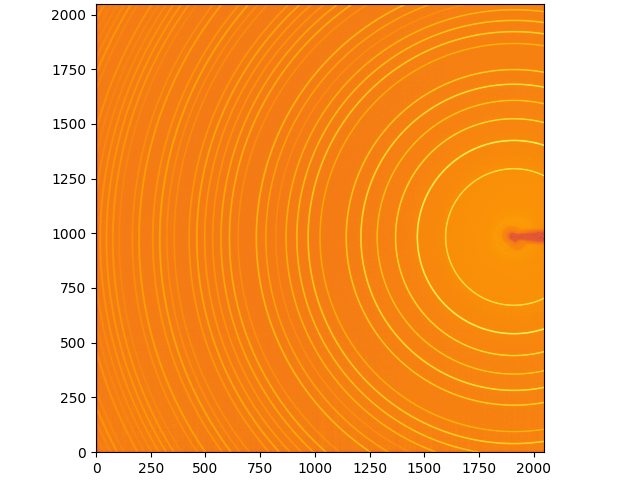

In [17]:
# this loads a tiff file using fabio package that is installed by pyFAI
img = fabio.open("from_PerkinElmer_detector/LaB6.tiff").data

fig = plt.figure()
ax = fig.add_subplot()
jupyter.display(img,ax=ax);

In [ ]:
# Definition of the detector and of the calibrant:
detector  = pyFAI.detector_factory("Perkin Elmer")
calibrant = CALIBRANT_FACTORY("LaB6")
calibrant.wavelength = 0.1814*1e-10 # wavelength is usually provided by the beamline scientist

calib = Calibration(img, calibrant=calibrant, wavelength=calibrant.wavelength, detector=detector)

# 1. Set the ring number (0-based value), below the plot
# 2. Pick the ring by right-clicking with the mouse on the image.
# 3. Restart at 1. for at least a second ring
# 4. Click refine to launch the calibration.

In [24]:
# This is the calibrated geometry:
gr = calib.geoRef
print(gr)
print(f"Fixed parameters: {calib.fixed}")
print(f"Cost function: {gr.chi2()}")

Detector Perkin detector	 PixelSize= 2.000e-04, 2.000e-04 m
Wavelength= 1.814000e-11 m
SampleDetDist= 1.428040e+00 m	PONI= 2.333484e-01, 3.753925e-01 m	rot1=-0.004660  rot2=-0.025685  rot3=0.000000 rad
DirectBeamDist= 1428.526 mm	Center: x=1910.235, y=983.302 pix	Tilt= 1.496° tiltPlanRotation= -79.719° 𝛌= 0.181Å
Fixed parameters: ['wavelength', 'rot3']
Cost function: 9.923796462845002e-07


In [25]:
# re-extract all control points using the "massif" algorithm
calib.extract_cpt()

In [26]:
# This is the geometry with all rings defined:
gr = calib.geoRef
print(gr)
print(f"Fixed parameters: {calib.fixed}")
print(f"Cost function: {gr.chi2()}")

Detector Perkin detector	 PixelSize= 2.000e-04, 2.000e-04 m
Wavelength= 1.814000e-11 m
SampleDetDist= 1.428040e+00 m	PONI= 2.333484e-01, 3.753925e-01 m	rot1=-0.004660  rot2=-0.025685  rot3=0.000000 rad
DirectBeamDist= 1428.526 mm	Center: x=1910.235, y=983.302 pix	Tilt= 1.496° tiltPlanRotation= -79.719° 𝛌= 0.181Å
Fixed parameters: ['wavelength', 'rot3']
Cost function: 1.8279469074553728e-05


In [27]:
# Create a azimuthal integrator (without fitting capabilities from the geometry-refinement object)
ai_recalibrated = pyFAI.load(gr)
ai_recalibrated

Detector Perkin detector	 PixelSize= 2.000e-04, 2.000e-04 m
Wavelength= 1.814000e-11 m
SampleDetDist= 1.428040e+00 m	PONI= 2.333484e-01, 3.753925e-01 m	rot1=-0.004660  rot2=-0.025685  rot3=0.000000 rad
DirectBeamDist= 1428.526 mm	Center: x=1910.235, y=983.302 pix	Tilt= 1.496° tiltPlanRotation= -79.719° 𝛌= 0.181Å

/usr/local/lib/python3.10/dist-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


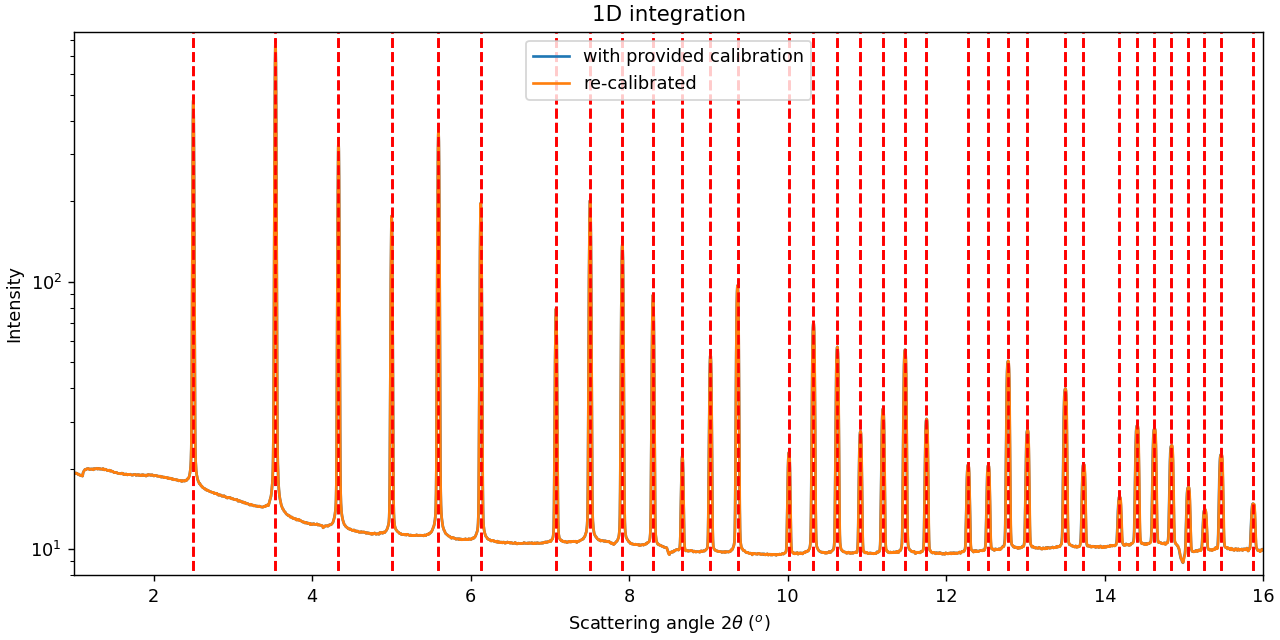

/usr/local/lib/python3.10/dist-packages/ipympl/backend_nbagg.py:279: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.manager.handle_json(content)


In [28]:
# Display the integrated data to validate the calibration.
# Note that calibration with provided (from_PerkinElmer_detector/calibration.poni)
# is almost same as the re-calibrated one. Therefore, blue and orange is very similar.

from matplotlib.pyplot import subplots
fig, ax = subplots(1, 1, figsize=(10, 5), dpi=128)
jupyter.plot1d(ai_provided.integrate1d(img, npt=5000, unit='2th_deg', method='bbox'),
               calibrant=calibrant, ax=ax, label='with provided calibration')

jupyter.plot1d(ai_recalibrated.integrate1d(img, npt=5000, unit='2th_deg', method='bbox'),
               calibrant=calibrant, ax=ax, label='re-calibrated')

ax.set_xlim([1,16])
ax.set_ylim(bottom=8)
ax.set_yscale('log')

In [29]:
# as expected, the difference between ai_provided and ai_recalibrated is small
print(ai_provided)
print('\n\n')
print(ai_recalibrated)

Detector Perkin detector	 PixelSize= 2.000e-04, 2.000e-04 m
Wavelength= 1.814000e-11 m
SampleDetDist= 1.428018e+00 m	PONI= 2.339843e-01, 3.763491e-01 m	rot1=-0.003994  rot2=-0.026133  rot3=-0.000000 rad
DirectBeamDist= 1428.517 mm	Center: x=1910.265, y=983.288 pix	Tilt= 1.515° tiltPlanRotation= -81.312° 𝛌= 0.181Å



Detector Perkin detector	 PixelSize= 2.000e-04, 2.000e-04 m
Wavelength= 1.814000e-11 m
SampleDetDist= 1.428040e+00 m	PONI= 2.333484e-01, 3.753925e-01 m	rot1=-0.004660  rot2=-0.025685  rot3=0.000000 rad
DirectBeamDist= 1428.526 mm	Center: x=1910.235, y=983.302 pix	Tilt= 1.496° tiltPlanRotation= -79.719° 𝛌= 0.181Å


# Integrating images with azimuthal integrator (ai) object

In [30]:
# As explained in the previous section, we can read ai through a provided poni file or generate it by performing a calibration.
# A third option is to define it as in the following


ai_dict = {
    'detector_name':"Perkin Elmer",
    'wavelength':1.814000e-11,
    'detector_dist':1.4280177479893559,
    'detector_poni1':0.23398429857415295,
    'detector_poni2':0.37634908408057827,
    'detector_rot1':-0.003994332959290178,
    'detector_rot2':-0.026132616520970278,
    'detector_rot3':-4.71036871681453e-10,
    'ai_from':'20240122-191827_step_scan_uid=4d94f1ef__LaB6.nc'
}
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
ai = AzimuthalIntegrator(
    detector=ai_dict['detector_name'],
    wavelength=ai_dict['wavelength'],
    dist=ai_dict['detector_dist'],
    poni1=ai_dict['detector_poni1'],
    poni2=ai_dict['detector_poni2'],
    rot1=ai_dict['detector_rot1'],
    rot2=ai_dict['detector_rot2'],
    rot3=ai_dict['detector_rot3'],
)

ai

Detector Perkin detector	 PixelSize= 2.000e-04, 2.000e-04 m
Wavelength= 1.814000e-11 m
SampleDetDist= 1.428018e+00 m	PONI= 2.339843e-01, 3.763491e-01 m	rot1=-0.003994  rot2=-0.026133  rot3=-0.000000 rad
DirectBeamDist= 1428.517 mm	Center: x=1910.265, y=983.288 pix	Tilt= 1.515° tiltPlanRotation= -81.312° 𝛌= 0.181Å

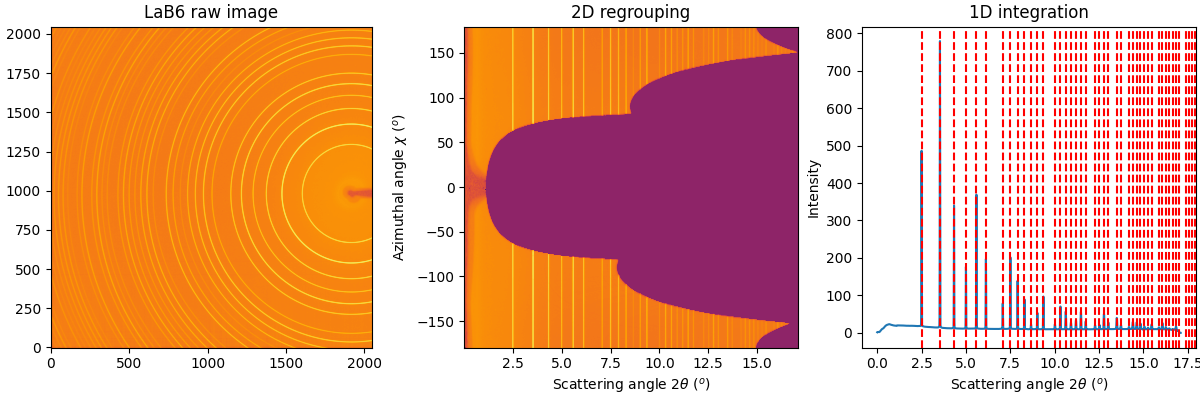

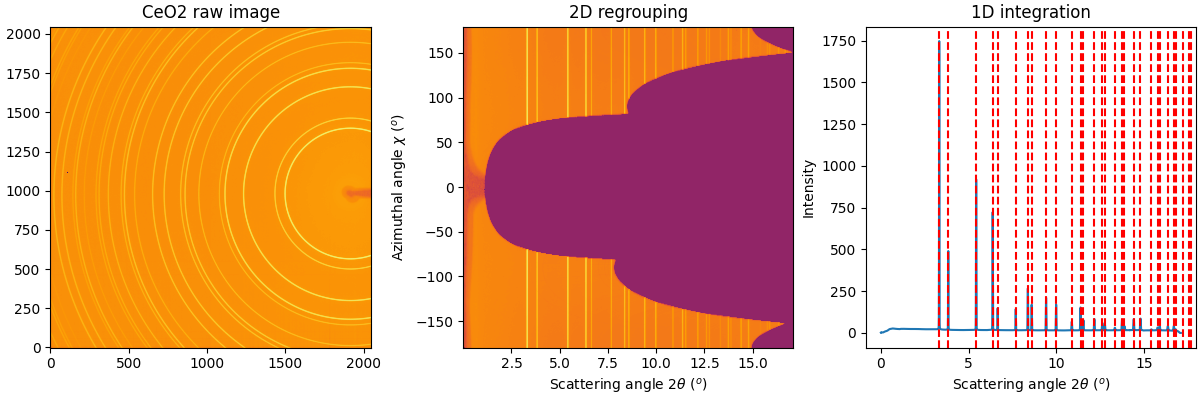

In [31]:
# for LaB6
img = fabio.open("from_PerkinElmer_detector/LaB6.tiff").data
i2d = ai.integrate2d(img, npt_rad=5000, npt_azim=350, unit='2th_deg', method='bbox') # 2D integrated image (i.e. cake)
i1d = ai.integrate1d(img, npt=5000, unit='2th_deg', method='bbox') # 1D integrated profile
calibrant = CALIBRANT_FACTORY("LaB6")
calibrant.wavelength = ai.wavelength


fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)
jupyter.display(img,ax=ax);
ax.set_title('LaB6 raw image')
ax = fig.add_subplot(1,3,2)
jupyter.plot2d(i2d,ax=ax);
ax = fig.add_subplot(1,3,3)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax);



# for CeO2
img = fabio.open("from_PerkinElmer_detector/CeO2.tiff").data
i2d = ai.integrate2d(img, npt_rad=5000, npt_azim=350, unit='2th_deg', method='bbox') # 2D integrated image (i.e. cake)
i1d = ai.integrate1d(img, npt=5000, unit='2th_deg', method='bbox') # 1D integrated profile
calibrant = CALIBRANT_FACTORY("CeO2")
calibrant.wavelength = ai.wavelength

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)
jupyter.display(img,ax=ax);
ax.set_title('CeO2 raw image')
ax = fig.add_subplot(1,3,2)
jupyter.plot2d(i2d,ax=ax);
ax = fig.add_subplot(1,3,3)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax);

# Applying mask for the integration.

<ipython-input-32-4ec4a093cceb>:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


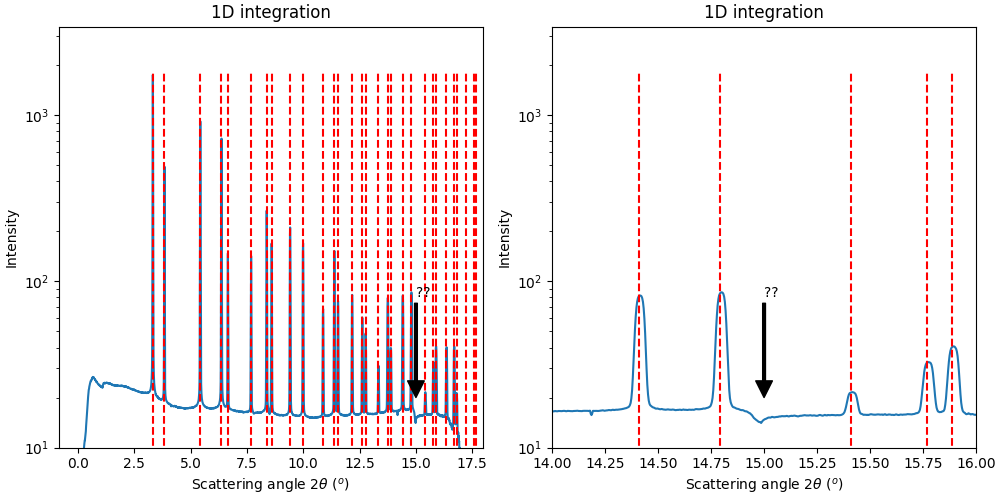

In [32]:
# If you look closely, there are some weird kings in the spectrum.
# They are coming from detector artefacts and beamstop and we need to mask them.

fig = plt.figure(figsize=(10,5))


ax = fig.add_subplot(1,2,1)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax);
ax.set_yscale('log')
ax.set_ylim(bottom=10)
ax.annotate('??', xy=(15,20), xytext=(15,80),arrowprops=dict(width=2,facecolor='black'))

ax = fig.add_subplot(1,2,2)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax);
ax.set_yscale('log')
ax.set_xlim([14,16])
ax.set_ylim(bottom=10)
ax.annotate('??', xy=(15,20), xytext=(15,80),arrowprops=dict(width=2,facecolor='black'))

plt.tight_layout()

In [ ]:
# You can create a mask by running "pyFAI-drawmask" utilty that comes with pyFAI.
# Below is a screenshot from that. Once mask is done, you can save it as edf and use as shown in next cell.

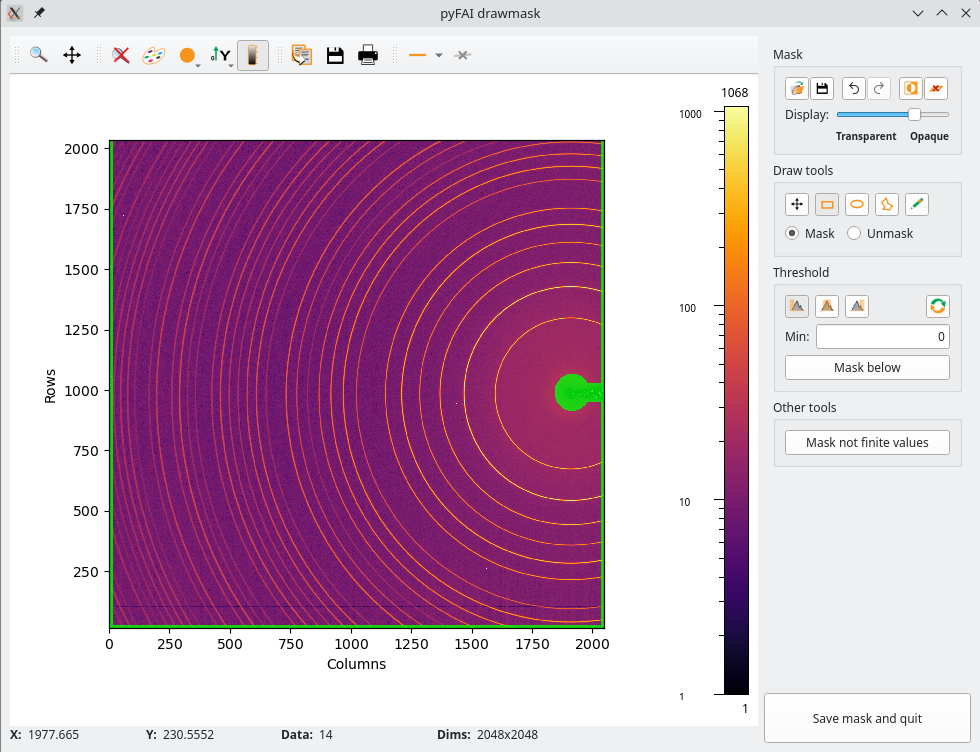

<ipython-input-33-7171f2073747>:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


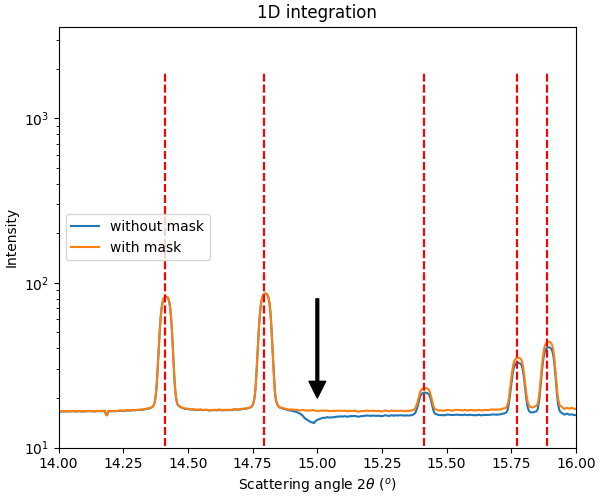

In [33]:
# load mask
mask = fabio.open("from_PerkinElmer_detector/LaB6_mask.edf").data

# then use
i1d_with_mask = ai.integrate1d(img, mask=mask, npt=5000, unit='2th_deg', method='bbox') # 1D integrated profile


fig = plt.figure(figsize=(6,5))

ax = fig.add_subplot(1,1,1)
jupyter.plot1d(i1d,calibrant=calibrant,ax=ax,label='without mask');
jupyter.plot1d(i1d_with_mask,calibrant=calibrant,ax=ax,label='with mask');

ax.set_yscale('log')
ax.set_xlim([14,16])
ax.set_ylim(bottom=10)
ax.annotate('', xy=(15,20), xytext=(15,80),arrowprops=dict(width=2,facecolor='black'))

plt.tight_layout()

# Exporting integrated 1d profile for subsequent analysis or plotting

In [35]:
# Exporting is straightforward. You just need to add filename='xxx' to the integrator
i1d = ai.integrate1d(img, mask=mask,
                     npt=5000, filename = "from_PerkinElmer_detector/LaB6.xy",
                     unit='2th_deg', method='bbox')

In [42]:
# on posix systems, we can see first 40 lines of the exported xy file
try:
    ! head -n 40 from_PerkinElmer_detector/LaB6.xy
except:
    pass

# {
#     "poni_version": 2.1,
#     "detector": "Perkin",
#     "detector_config": {
#         "pixel1": 0.0002,
#         "pixel2": 0.0002,
#         "orientation": 3
#     },
#     "dist": 1.4280177479893559,
#     "poni1": 0.23398429857415295,
#     "poni2": 0.37634908408057827,
#     "rot1": -0.003994332959290178,
#     "rot2": -0.026132616520970278,
#     "rot3": -4.71036871681453e-10,
#     "wavelength": 1.814e-11
# }
# Mask applied: user provided
# Dark current applied: False
# Flat field applied: False
# Polarization factor: None
# Normalization factor: 1.0
# --> from_PerkinElmer_detector/LaB6.xy
#       2th_deg             I 
  5.256463e-01    2.840588e+01
  5.289282e-01    2.885172e+01
  5.322102e-01    2.886941e+01
  5.354921e-01    2.888246e+01
  5.387741e-01    2.863218e+01
  5.420560e-01    2.870976e+01
  5.453379e-01    2.887658e+01
  5.486199e-01    2.903121e+01
  5.519018e-01    2.893878e+01
  5.551838e-01    2.886610e+01
  5.584657e-01    2.890649e+01
  5.617477e-01 

In [50]:
# if we don't want header lines in the exported xy file, we can export it using np.savetxt as below.

out = np.column_stack( (i1d.radial, i1d.intensity) )
np.savetxt('from_PerkinElmer_detector/LaB6.xy',out,fmt=' %.4e  %.4e')

In [51]:
# on posix systems, we can see first 40 lines of the exported xy file
try:
    ! head -n 40 from_PerkinElmer_detector/LaB6.xy
except:
    pass

 5.2565e-01  2.8406e+01
 5.2893e-01  2.8852e+01
 5.3221e-01  2.8869e+01
 5.3549e-01  2.8882e+01
 5.3877e-01  2.8632e+01
 5.4206e-01  2.8710e+01
 5.4534e-01  2.8877e+01
 5.4862e-01  2.9031e+01
 5.5190e-01  2.8939e+01
 5.5518e-01  2.8866e+01
 5.5847e-01  2.8906e+01
 5.6175e-01  2.8907e+01
 5.6503e-01  2.8819e+01
 5.6831e-01  2.8828e+01
 5.7159e-01  2.8902e+01
 5.7488e-01  2.9033e+01
 5.7816e-01  2.9069e+01
 5.8144e-01  2.8949e+01
 5.8472e-01  2.8940e+01
 5.8800e-01  2.8933e+01
 5.9129e-01  2.8951e+01
 5.9457e-01  2.8930e+01
 5.9785e-01  2.8943e+01
 6.0113e-01  2.8990e+01
 6.0441e-01  2.8938e+01
 6.0769e-01  2.8913e+01
 6.1098e-01  2.8968e+01
 6.1426e-01  2.8919e+01
 6.1754e-01  2.8872e+01
 6.2082e-01  2.8934e+01
 6.2410e-01  2.9093e+01
 6.2739e-01  2.9206e+01
 6.3067e-01  2.9275e+01
 6.3395e-01  2.9298e+01
 6.3723e-01  2.9318e+01
 6.4051e-01  2.9271e+01
 6.4380e-01  2.9392e+01
 6.4708e-01  2.9508e+01
 6.5036e-01  2.9621e+01
 6.5364e-01  2.9653e+01


In [54]:
# there exist more options for ai.integrate1d.
# see docstring below

ai.integrate1d?

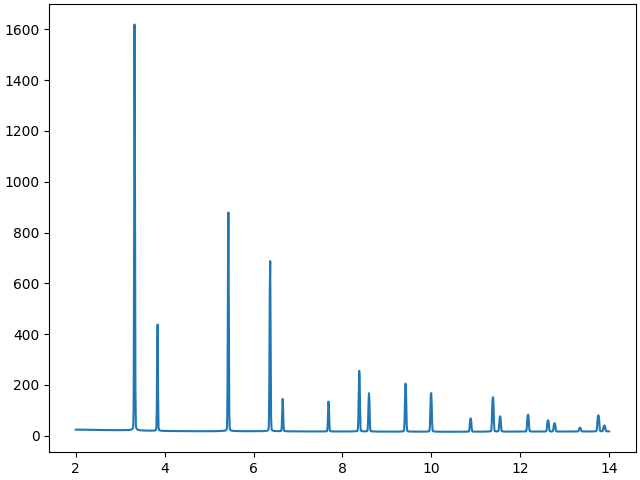

In [56]:
# For example, if we want to limit radial range from 2 to 14 with 1200 points, we can do it like this:

i1d = ai.integrate1d(img, mask=mask, radial_range = (2,14),
                     npt=1200, filename = "from_PerkinElmer_detector/LaB6.xy",
                     unit='2th_deg', method='bbox')

data = np.loadtxt('from_PerkinElmer_detector/LaB6.xy',unpack=True)
plt.figure()
plt.plot(data[0],data[1])